In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import sklearn
import torch
from torch.utils.data import TensorDataset, DataLoader
from torch import nn
from torch import optim
from torch import mps
from torch.nn import Mish
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler, PowerTransformer, minmax_scale, power_transform, scale, minmax_scale
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from tqdm.auto import tqdm
# from tqdm import tqdm
import os
from ranger21 import Ranger21
from pytorch_ranger import Ranger
import hdbscan

import lightning.pytorch as pl

from helpers.cross_sectorial import CS_DATAMODULE_2D, CS_DATAMODULE_1D, _format_tensors_cs_1D
from models.cross_sectorial import P_MH_CNN_2D_LSTM, P_CNN_2D_LSTM, MH_CNN_2D_LSTM, LSTM, CNN_1D_LSTM

# Set global seed for reproducibility in numpy, torch, scikit-learn
pl.seed_everything(42)
# torch.manual_seed(42)
# torch.mps.manual_seed(42)
# torch.backends.mps.deterministic = True
# torch.cuda.manual_seed(42)
# torch.backends.cudnn.deterministic = True
# np.random.seed(42)
%autosave 0
import warnings
warnings.filterwarnings("ignore")

c:\Users\John\miniconda3\envs\master_thesis\lib\site-packages\torchaudio\backend\utils.py:74: UserWarning: No audio backend is available.
  warnings.warn("No audio backend is available.")
c:\Users\John\miniconda3\envs\master_thesis\lib\site-packages\umap\distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
c:\Users\John\miniconda3\envs\master_thesis\lib\site-packages\umap\distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/ref

Autosave disabled


In [ ]:
fin_data = pd.read_parquet("./DATA/Monthly/Processed/month_data_fin_tec.parquet")
macro_data = pd.read_parquet("./DATA/Monthly/Processed/month_data_macro_USCA.parquet")
with open("./DATA/Tickers/month_tickers_clean.txt", "r") as file:
    tickers = file.read().strip().split("\n")

In [ ]:
_format_tensors_cs_1D(fin_data=fin_data,
                      macro_data=macro_data,
                      tickers=tickers,
                      lookback=12,
                      pred_horizon=1,
                      multistep=False,
                      pred_target="return",
                      red_each_dim=2,)

In [ ]:
data = CS_DATAMODULE_1D(batch_size=32,
                        lookback=12,
                        pred_horizon=1,
                        multistep=False,
                        data_type="monthly",
                        train_workers=0,
                        overwrite_cache=True,
                        pred_target="return",
                        cluster=None,
                        only_prices=False,
                        umap_dim=10)
data.prepare_data()
data.setup()

In [ ]:
N_COMPANIES = int(len(data.tickers))
N_FEATURES = int(data.X_train_tensor.shape[-1])
# Batches per epoch which have to be rounded up to the next integer
N_BATCHES = int(np.ceil(len(data.X_train_tensor) / 32))
print(f"Number of batches per Epoch: {N_BATCHES}")

model = LSTM(n_companies=N_COMPANIES,
                n_features=N_FEATURES,
                lookback=12,
                epochs=100,
                batches_p_epoch=N_BATCHES,
                lstm_layers=2,
                lstm_nodes=256,
                fc_layers=1,
                fc_nodes=500,
                dropout=0.2,
                bidirectional=False,
                lr=1e-4,
                optimizer=Ranger,
                activation=Mish(True),)

In [ ]:
x_in, y_in = next(iter(data.train_dataloader()))
x_in.shape, y_in.shape

In [ ]:
model.fc

In [ ]:
model(x_in).shape

In [ ]:
len(data.X_train_tensor), len(data.X_val_tensor), len(data.X_test_tensor)

In [ ]:
len(data.y_train_tensor), len(data.y_val_tensor), len(data.y_test_tensor)

In [ ]:
(257 + 24), 

In [ ]:
fin_data.filter(regex="_CP$")

In [ ]:
y_in[0]

# CLUSTERING (ADD TO ETL!!!)

### KMEANS

In [ ]:
val_prices = fin_data.filter(regex="_CP$").iloc[-2]
val_prices.min(), val_prices.max(), val_prices.mean(), val_prices.std(), val_prices.median()

In [ ]:
(val_prices <= 10).sum(), ((val_prices > 10) & (val_prices <= 100)).sum(), ((val_prices > 100) & (val_prices <= 200)).sum(), (val_prices > 200).sum()

In [ ]:
# use quantiles to group data into 5 bins
bins = pd.cut(val_prices, 3, labels=False)

# create a dataframe with the bins and the corresponding prices
df = pd.DataFrame({'bins': bins, 'CP': val_prices})
# See min, max, and count of each bin
df.groupby('bins')['CP'].agg(['min', 'max', 'count'])

In [ ]:
scaler = StandardScaler().set_output(transform="pandas")
data = scaler.fit_transform(fin_data.filter(regex="_CP$")).iloc[-2] #.iloc[-3:-1].T
data = pd.DataFrame(data.T.values.reshape(-1, 1), index=data.index, columns=["Close 30-04-2023"])

In [ ]:
inertia_values = []
for n_clusters in range(1, 11):
    kmeans = KMeans(n_clusters=n_clusters)
    kmeans.fit(data)
    inertia_values.append(kmeans.inertia_)

# Plot the Elbow curve
plt.plot(range(1, 11), inertia_values, marker='o')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia (Within-cluster Sum of Squares)')
plt.title('Elbow Method')
plt.show()

In [ ]:
silhouette_scores = []
for n_clusters in range(2, 11):
    kmeans = KMeans(n_clusters=n_clusters)
    cluster_labels = kmeans.fit_predict(data)
    silhouette_avg = silhouette_score(data, cluster_labels)
    silhouette_scores.append(silhouette_avg)

# Plot the Silhouette Score
plt.plot(range(2, 11), silhouette_scores, marker='o')
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score Method')
plt.show()

### HDBSCAN

In [ ]:
hdb = hdbscan.HDBSCAN(min_cluster_size=10, min_samples=100, cluster_selection_method='leaf')
hdb_labels = hdb.fit_predict(data)

In [ ]:
data["cluster"] = hdb_labels

In [ ]:
plt.scatter(data.index, data["Close 30-04-2023"], c=cluster_labels, cmap='viridis', s=50)
plt.xlabel('Asset')
plt.ylabel('Close Price')
plt.title('HDBSCAN Clustering')
plt.show()

### Intuition and stats show around 3 clusters seem best (intuition low, medium, high prices)

In [ ]:
clusterer = KMeans(n_clusters=4) # Classify asset price as low mid high
clusterer.fit(data)
data["cluster"] = clusterer.labels_

In [ ]:
data["cluster"].value_counts()

In [ ]:
# Get the max and min price for each ticker in clusters[0]
clusters = []
for cluster in data['cluster'].unique():
    clusters.append(data[data["cluster"] == cluster].index.str.removesuffix("_CP").tolist())
    
for i, cluster in enumerate(clusters):
    maxs = []
    mins = []
    for ticker in cluster:
        maxs.append(fin_data[f"{ticker}_CP"].iloc[-2].max())
        mins.append(fin_data[f"{ticker}_CP"].iloc[-2].min())

    print(f"Min price for cluster {i}: {min(mins)}")
    print(f"Max price for cluster {i}: {max(maxs)}")
    print(f"Mean price for cluster {i}: {np.mean(maxs)}")
    print(f"Median price for cluster {i}: {np.median(maxs)}")
    print(f"Std price for cluster {i}: {np.std(maxs)}")
    print()

### Save clustered cs data

In [ ]:
for cluster in data['cluster'].unique():
    with open(f"./DATA/Tickers/month_tickers_clean_cluster{cluster}.txt", "w") as file:
        file.write("\n".join(data[data["cluster"] == cluster].index.str.removesuffix("_CP").tolist()))

## Init data

In [ ]:
LEARING_RATE = 1e-4 # 1e-4 ind standard
EPOCHS = 3
BATCH_SIZE = 32 # Small batch size since we are using a small dataset

In [ ]:
data = CS_DATAMODULE(batch_size=BATCH_SIZE, lookback=12, pred_horizon=1, multistep=False, data_type="monthly")

In [ ]:
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
device

In [ ]:
data.prepare_data()
data.setup()
data.X_train_tensor.shape

In [ ]:
data.X_train_tensor.min(), data.X_train_tensor.max(), data.X_val_tensor.min(), data.X_val_tensor.max(), data.X_test_tensor.min(), data.X_test_tensor.max()

In [ ]:
# Get first iter of train loader using next
x_in, y_in = next(iter(data.train_dataloader()))

In [ ]:
x_in.shape, y_in.shape

In [ ]:
x_in.reshape(x_in.shape[0], x_in.shape[2], x_in.shape[1], 1, x_in.shape[3]).shape

## CNN LSTM

In [2]:
data = CS_DATAMODULE_2D(batch_size=32, lookback=12, pred_horizon=1, multistep=False, data_type="monthly", pred_target="return", overwrite_cache=False)
data.prepare_data()
data.setup()

BATCH_SIZE = 32
N_COMPANIES = int(len(data.tickers))
N_FEATURES = int(data.X_train_tensor.shape[-1])
# Batches per epoch which have to be rounded up to the next integer
N_BATCHES = int(np.ceil(len(data.X_train_tensor) / BATCH_SIZE))
print(f"Number of batches per Epoch: {N_BATCHES}")

Number of batches per Epoch: 9


In [3]:
model = MH_CNN_2D_LSTM(n_companies=N_COMPANIES,
                 n_features=N_FEATURES,
                 lookback=12,
                 epochs=100,
                 batches_p_epoch=N_BATCHES,
                 cnn_layers=3,
                 conv_factor=0.5,
                 lstm_layers=2,
                 lstm_nodes=512,
                 fc_layers=3,
                 fc_nodes=N_COMPANIES,
                 dropout=0.3,
                 bidirectional=True,
                 lr=1e-4,
                 optimizer=Ranger21,
                 activation=Mish(True),)

In [4]:
data.X_train_tensor.shape, data.X_val_tensor.shape, data.X_test_tensor.shape, data.y_train_tensor.shape, data.y_val_tensor.shape, data.y_test_tensor.shape

(torch.Size([266, 409, 12, 154]),
 torch.Size([1, 409, 12, 154]),
 torch.Size([1, 409, 12, 154]),
 torch.Size([266, 409]),
 torch.Size([1, 409]),
 torch.Size([1, 409]))

In [5]:
model

MH_CNN_2D_LSTM(
  (activation): Mish(inplace=True)
  (loss_fn): MSELoss()
  (conv1d_channels): ModuleList(
    (0-408): 409 x Sequential(
      (0): Conv1d(154, 77, kernel_size=(1,), stride=(1,))
      (1): Mish(inplace=True)
      (2): BatchNorm1d(77, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (3): Conv1d(77, 38, kernel_size=(1,), stride=(1,))
      (4): Mish(inplace=True)
      (5): BatchNorm1d(38, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (6): Conv1d(38, 19, kernel_size=(1,), stride=(1,))
      (7): Mish(inplace=True)
      (8): BatchNorm1d(19, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
  )
  (lstm): LSTM(7771, 512, num_layers=2, batch_first=True, dropout=0.3, bidirectional=True)
  (fc): Sequential(
    (0): Linear(in_features=1024, out_features=409, bias=True)
    (1): Mish(inplace=True)
    (2): Dropout(p=0.3, inplace=False)
    (3): Linear(in_features=409, out_features=409, bias=True)
    (4): Mish(

In [6]:
x_in, y_in = next(iter(data.train_dataloader()))

out = model(x_in)
out.shape

torch.Size([32, 409])

In [ ]:
data.y_train_tensor.shape

In [ ]:
out[0].shape

In [ ]:
out=out[0, :, :]

In [ ]:
out.shape

In [ ]:
out[9, :, :].shape

In [ ]:
# Calculate how convolution changes shape from [1, 169, 12, 159]) to [1, 32, 3, 39])

12 // (2 ** 2), 159 // (2 ** 2), 

## Conv AE

In [ ]:
x_in.shape

In [ ]:
convae = Conv2D_AE_LSTM(in_channels=409, lstm_hidden=2, lookback=12, num_features=159, batch_size=32, lr=1e-3)

In [ ]:
convae(x_in).shape

In [ ]:
from torchinfo import summary

summary(convae, input_size=(BATCH_SIZE, 409, 12, 159), col_names=["input_size", "output_size", "num_params", "trainable"])

## Video Conv JP Morgan Approach

In [ ]:
BATCH_SIZE = 32
LOOKBACK = 12*21
LEARNING_RATE = 1e-5

In [ ]:
data = CS_VID_DATAMODULE(batch_size=BATCH_SIZE, lookback=LOOKBACK, pred_horizon=21, multistep=True, data_type="daily", overwrite_cache=True, pred_target="return")

In [ ]:
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
device

In [ ]:
from helpers.cross_sectorial import _format_tensors_cs_vid
fin_data = pd.read_parquet("./DATA/Daily/Processed/day_data_fin_tec.parquet")
X_train, X_val, X_test, y_train, y_val, y_test = _format_tensors_cs_vid(fin_data, lookback=12*21, pred_horizon=21, multistep=True, resize=None, pred_target="return")

In [ ]:
X_train.shape, y_train.shape

In [ ]:
X_train.shape, X_val.shape

In [ ]:
y_train.shape, y_val.shape

In [ ]:
from torchvision.transforms.functional import resize
resize(z.unsqueeze(dim=0), (64,64)).squeeze().shape

In [ ]:
z.max(), z.round().min()

In [ ]:
torch.nn.Sigmoid()(z).min(), torch.nn.Sigmoid()(z).max()

In [ ]:
data.prepare_data()
data.setup()
data.X_train_tensor.shape

In [ ]:
data.X_train_tensor.shape, data.X_val_tensor.shape, data.X_test_tensor.shape

In [ ]:
data.y_train_tensor.shape, data.y_val_tensor.shape, data.y_test_tensor.shape

In [ ]:
np.isnan(data.X_train_tensor.numpy()).sum()

In [ ]:
data.X_train_tensor.min(), data.X_train_tensor.max(), data.X_val_tensor.min(), data.X_val_tensor.max(), data.X_test_tensor.min(), data.X_test_tensor.max()

In [ ]:
# Get first iter of train loader using next
x_in, y_in = next(iter(data.train_dataloader()))

In [ ]:
x_in.shape, y_in.shape

In [ ]:
x_in.squeeze().shape, y_in.squeeze().shape

In [ ]:
y_in.squeeze()[-1].shape

In [ ]:
from torchvision.utils import make_grid

plt.imshow(x_in.squeeze()[-1].numpy(), cmap="gray")

In [ ]:
plt.imshow(y_in.squeeze().numpy(), cmap="gray")

In [ ]:
convlstmae = ConvLSTM_AE(
    batch_size=BATCH_SIZE,
    lookback=LOOKBACK,
    pred_horizon=1,
    hidden_dim=64,
    lr=LEARNING_RATE,)

In [ ]:
x_in.shape, y_in.squeeze().shape

In [ ]:
pred1 = convlstmae(x_in)

In [ ]:
pred1.squeeze().shape

In [ ]:
pred1.min(), pred1.max(), pred1.mean(), pred1.std()

In [ ]:
x_in[0][-1].min(), x_in[0][-1].max(), x_in[0][-1].mean(), x_in[0][-1].std(), x_in[0][-1].median()

In [ ]:
show(torchvision.utils.make_grid(x_in[0]))

In [ ]:
plt.imshow(y_in.squeeze(), cmap="gray")

In [ ]:
plt.imshow(pred1.detach().cpu().squeeze(), cmap="gray")

In [ ]:
from torchinfo import summary

summary(convlstmae, input_size=(x_in.shape), col_names=["input_size", "output_size", "num_params", "trainable"])

## ConvAELSTM

### First lets get a convautoencoder working

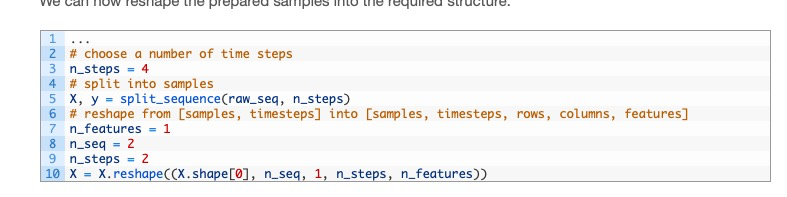

n_seq = 409 (num of companies - channels aka rows stays 1)

In [ ]:
from models.cross_sectorial import ConvLSTMCell, ConvLSTM

In [ ]:
x_in.shape

In [ ]:
u = x_in.reshape(x_in.shape[0], x_in.shape[1], 1, x_in.shape[2], x_in.shape[3])
u.shape

In [ ]:
zumba = ConvLSTMCell

In [ ]:
zumba(u)

In [ ]:
convae = Conv_AE_LSTM(channels_in=409, encoder_dim=256, lr=1e-3, batch_size=32, lookback=12, num_features=159)

In [ ]:
convae(x_in).shape

In [ ]:
from torchinfo import summary

summary(convae, input_size=(BATCH_SIZE, 409, 12, 159), col_names=["input_size", "output_size", "num_params", "trainable"])

In [ ]:
early_stopping = pl.callbacks.EarlyStopping(monitor="val_loss", patience=10, mode="min")
convae_checkpoint = pl.callbacks.ModelCheckpoint(save_top_k=1, monitor="val_loss", mode="min")

compiled_convae = torch.compile(convae, mode="reduce-overhead", backend="aot_eager")
mps.empty_cache()

convlstm_trainer = pl.Trainer(accelerator="gpu", max_epochs=200, log_every_n_steps=1, callbacks=[early_stopping, convae_checkpoint], enable_checkpointing=True, enable_progress_bar=True, default_root_dir="./lightning_logs/convae/")
convlstm_trainer.fit(model=compiled_convae, datamodule=data)
mps.empty_cache()

In [ ]:
%load_ext tensorboard
%tensorboard --logdir lightning_logs/

In [ ]:
print(f"Best model path: {convlstm_checkpoint.best_model_path}")
print(f"Best model score: {convlstm_checkpoint.best_model_score}")

In [ ]:
LEARNING_RATE = 1e-4 # 1e-4 ind standard
EPOCHS = 10_000
BATCH_SIZE = 32
LOOKBACK = 12
PRED_HORIZON = 1
MULTISTEP = False
TRAIN_WORKERS = 0 # 0 fastest ...

# data = CS_VID_DATAMODULE(batch_size=BATCH_SIZE, lookback=LOOKBACK, pred_horizon=PRED_HORIZON, multistep=MULTISTEP, data_type="monthly", resize=None, overwrite_cache=True, pred_target="return", train_workers=TRAIN_WORKERS)
data = CS_DATAMODULE(batch_size=BATCH_SIZE, lookback=LOOKBACK, pred_horizon=PRED_HORIZON, multistep=MULTISTEP, data_type="monthly", pred_target="price", overwrite_cache=False, cluster=0)

In [ ]:
# /Users/johnbergmann/Developer/Master-Thesis/lightning_logs/version_29/checkpoints/epoch=5493-step=49446.ckpt
# lightning_logs/convae/lightning_logs/version_22/checkpoints/epoch=8-step=306.ckpt
# lightning_logs\convae\lightning_logs\version_15\checkpoints\epoch=193-step=1746.ckpt
# BEST 4 NOW!: lightning_logs\\convae\\lightning_logs\\version_39\\checkpoints\\epoch=1923-step=17316.ckpt
best_model = CNN_2D_LSTM.load_from_checkpoint(checkpoint_path="lightning_logs\\convae\\lightning_logs\\version_45\\checkpoints\\epoch=974-step=8775.ckpt").to("cpu")

In [ ]:
data.prepare_data()
data.setup()
X_val_tensor = data.X_val_tensor.to("cpu")
y_val_tensor = data.y_val_tensor.to("cpu")

In [ ]:
X_val_tensor.shape, y_val_tensor.shape 

In [ ]:
data.y_train_tensor[-1].cpu().shape

In [ ]:
best_model.eval()
with torch.inference_mode():
    y_pred = best_model(X_val_tensor.to("cpu")).cpu().detach().numpy()

In [ ]:
# Plot predictions vs actuals

plt.figure(figsize=(15, 6))
plt.plot(y_val_tensor.squeeze(), label='actual')
plt.plot(data.y_train_tensor[-1].cpu(), label='last train sample')
plt.plot(y_pred.squeeze(), label='predicted')
plt.legend()
plt.show();

In [ ]:
# Plot predictions vs actuals

plt.figure(figsize=(15, 6))
plt.plot(data.y_train_tensor[-1].cpu(), label='last train sample')
plt.plot(y_pred.squeeze(), label='predicted')
plt.legend()
plt.show();


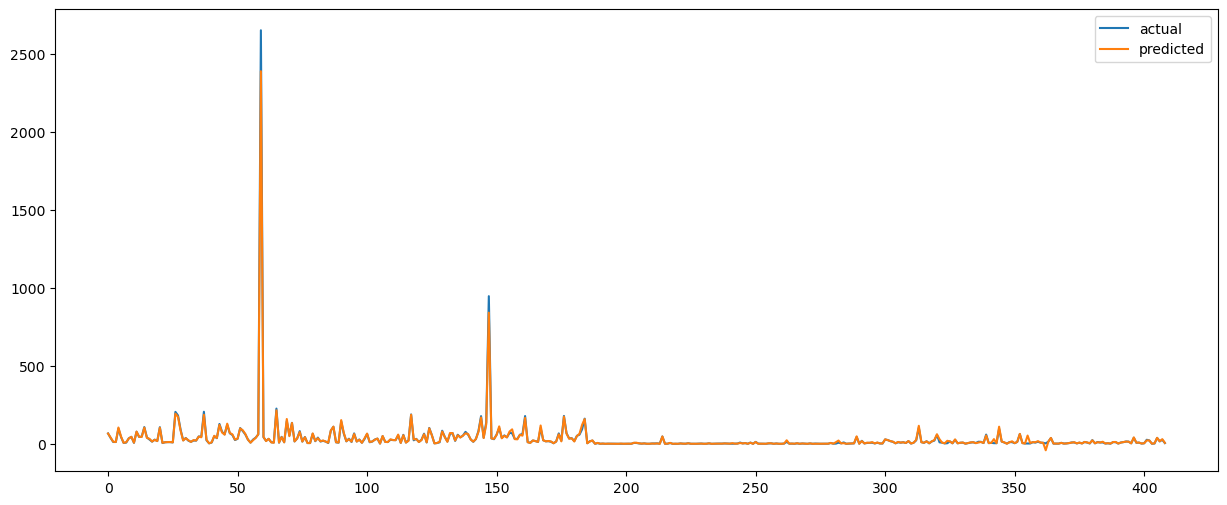

In [ ]:
# R2 score and MAPE
from sklearn.metrics import r2_score, mean_absolute_error, mean_absolute_percentage_error, mean_squared_error
print(f"R2 score: {r2_score(y_val_tensor.squeeze(), y_pred.squeeze()):.4f}")
print(f"MAPE: {mean_absolute_percentage_error(y_val_tensor, y_pred):.4%}")
print(f"MAE: {mean_absolute_error(y_val_tensor, y_pred):.4f}")

In [ ]:
# Show without scientific notation
np.set_printoptions(suppress=True)
np.round(y_pred.squeeze(), 2)

In [ ]:
y_val

create 2 cluster

# BAZINGA!